In [1]:
import numpy as np
import subprocess
import time
import copy
from utils.opt_utils import *
import os
import h5py
import pickle
from qutip import *

In [2]:
wc_A = 4.069814 * (10**9) * 2 * np.pi  # cavity A frequency
wc_B = 6.096062 * (10**9) * 2 * np.pi  # cavity A frequency
wa =  5.325 * (10**9) * 2 * np.pi  # atom frequency
dt_A = np.abs(wc_A - wa) / (2 * np.pi)
dt_B = np.abs(wc_B - wa) / (2 * np.pi)
chi_A = 0.00215 * (10**9) * 2 * np.pi
chi_B = 0.00544 * (10**9) * 2 * np.pi
g_A = np.sqrt(chi_A * dt_A) * 2 * np.pi  # coupling strength w/ cavity A
g_B = np.sqrt(chi_B * dt_B) * 2 * np.pi  # coupling strength w/ cavity B

gamma = 333333.333        # atom dissipation rate
kappa_A = 10000       # cavity A dissipation rate
kappa_B = 10000       # cavity B dissipation rate

temp_q = 0.01        # avg number of thermal bath excitation for qubit
temp_A = 0.04        # avg number of thermal bath excitation for cavity A
temp_B = 0.05        # avg number of thermal bath excitation for cavity B

In [3]:
cavity_dims = 8

# Cost function
def cost_q_e(final_expect, final_dm):
    # print(final_expect[0])
    return(final_expect[0])

def cost_qA_g1(final_expect, final_state):
    # print(final_dm.full())
    return np.power(np.abs(final_state.full()[1][0]), 2)

def cost_qA_g2(final_expect, final_state):
    # print(final_dm.full())
    return np.power(np.abs(final_state.full()[2][0]), 2)

def cost_qA_g3(final_expect, final_state):
    # print(final_dm.full())
    return np.power(np.abs(final_state.full()[3][0]), 2)

def cost_qA_g4(final_expect, final_state):
    # print(final_dm.full())
    return np.power(np.abs(final_state.full()[4][0]), 2)

def cost_qAB_g11(final_expect, final_dm):
    return np.power(np.abs(final_dm.full()[cavity_dims + 1][0]), 2)

def cost_qAB_g11_dm(final_expect, final_state):
    return np.power(np.abs(final_state[cavity_dims + 1][0]), 2)

def cost_qAB_g11_n(final_expect, final_dm):
    noise = (np.random.rand(1)[0] * 0.10) - 0.05
    return np.abs(final_dm.full()[cavity_dims + 1][0]) + noise

In [4]:
# ========== OPTIONS ========== #
max_segs = 20
time_start = 0.0000000
time_stop = 0.00000225
init_amp = 4000000
n_steps = 501

num_drives = 2
num_cavities = 1
# cavity_dims = 8
state_sizes = [2, cavity_dims]
state_vals = [0, 0]
init_freqs = [wa - wc_A, wc_A]
sim_options = Options()
element_freqs = [wa, wc_A]
drive_elem_nums = [0, 1]
output_cost_func = cost_qA_g2
elements = "qA"
start_split_num = 10
n_seg_jump = 1
verbose = True

load_pulse_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\ctrl_vqe_pi_pulse_sim_2g_interp'
load_times_file = r'opt_SNAP_times_1g.txt'
load_amps_file = r'opt_SNAP_amps_1g.txt'
use_loaded_data = False

save_dir = r'C:\Users\Wang_Lab\Documents\GitLab\quantum_control_rl_server\examples\ctrl_vqe_pi_pulse_sim_2g_interp\save_data'
hdf5_name = time.strftime('g11-n0-%Y%m%d-%H%M%S.h5')
epochs = 1000
epochs_per_seg = 500
train_batch_size = 20
qubit_amp_scale = 10
cavity_amp_scale = 10
freq_scale = 0.0005
# ========== OPTIONS ========== #

t_arr = np.linspace(time_start, time_stop, n_steps)

t_step = (time_stop - time_start) / n_steps

sim_options.store_final_state = True

qscale = []
cscale = []
for i in range(2 * start_split_num):
    qscale.append(init_amp * qubit_amp_scale)
    cscale.append(init_amp * cavity_amp_scale)
    cscale.append(init_amp * cavity_amp_scale)

sm, a_A, a_B, sx, sz = reg_ops(num_cavities + 1, cavity_dims)
drive_freqs = np.array(init_freqs)

gammas = [gamma, kappa_A]
temps = [temp_q, temp_A]
c_ops = [] # gen_c_ops(elements, [sm, a_A, a_B, sx, sz], gammas, temps)

# Operators used in Hamiltonian
drive_ops = [sm.dag(), sm, a_A.dag(), a_A]
element_ops = [sz, a_A.dag() * a_A]
H_0 = (chi_A * a_A.dag() * a_A * sz)
eval_ops = [sm.dag() * sm, a_A.dag() * a_A] # [sm.dag() * sm, a_A.dag() * a_A, a_B.dag() * a_B] # [sm.dag() * sm, a_A.dag() * a_A, a_B.dag() * a_B, tensor(destroy(2) * destroy(2).dag(), destroy(cavity_dims).dag() * destroy(cavity_dims), destroy(cavity_dims).dag() * destroy(cavity_dims))]

t_segs, amp_segs = setup_interp_segs(2 * num_drives, time_start, time_stop, init_amp)

t_segs = t_segs[:, 1:-1]

# for i in range(start_split_num - 1):
#     t_segs, amp_segs = split_segs(t_segs, amp_segs)

# Setup initial state
# init_state = build_psi(state_sizes, state_vals)
init_state = tensor((basis(state_sizes[0], 0) * np.sqrt(1 - state_vals[0])) + (basis(state_sizes[0], 1) * np.sqrt(state_vals[0])), (basis(state_sizes[1], 0) * np.sqrt(1 - state_vals[1])) + (basis(state_sizes[1], 1) * np.sqrt(state_vals[1])))

amp_segs = np.reshape(amp_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))

t_segs = np.reshape(t_segs, (num_drives * 2, int(len(t_segs.flatten()) / (num_drives * 2))))

for i in range(start_split_num - 1):
    t_segs, amp_segs = split_segs_flat(interp_time_wrapper(t_segs, time_start, time_stop), interp_amp_wrapper(amp_segs))
    t_segs = t_segs[:, 1:-1]
    
t_segs = interp_time_wrapper(t_segs, time_start, time_stop)

flip_bits = np.array([[False, False, True, True]])
flip_mask = np.array([np.repeat(flip_bits, np.ceil(start_split_num / 4), axis=0).flatten()[:start_split_num]])
flip_mask = np.repeat([flip_mask], num_drives * 2, axis=1)[0]

amp_segs[flip_mask] *= -1

if use_loaded_data:
    print("Loading data")
    load_pulse_times = np.loadtxt(str(os.path.join(load_pulse_dir, load_times_file)))
    load_pulse_amps = np.loadtxt(str(os.path.join(load_pulse_dir, load_amps_file)))
    
    t_segs = np.array(load_pulse_times)
    amp_segs = np.array(load_pulse_amps)

print(f't_segs: {t_segs}')

print(f'amp_segs: {amp_segs}')

# Create blank history arrays for storing optimal / past values
time_hist = []
amp_hist = []
freq_hist = []
cost_hist = []

[1.19496251e-06]
[9.09759266e-07]
[4.5299726e-07]
[1.23871482e-06]
t_segs: [[0.00000000e+00 8.84227132e-08 2.42967683e-07 4.85512655e-07
  6.47914305e-07 8.42495554e-07 1.03073859e-06 1.19496251e-06
  1.40913433e-06 1.72449776e-06 1.94214784e-06 2.25000000e-06]
 [0.00000000e+00 3.89490355e-07 4.40500733e-07 6.15153851e-07
  8.64871405e-07 9.09759266e-07 1.26129912e-06 1.60417124e-06
  1.63924006e-06 1.80536557e-06 1.92284858e-06 2.25000000e-06]
 [0.00000000e+00 1.60092959e-07 4.52997260e-07 6.96099587e-07
  8.95411656e-07 1.13770688e-06 1.47087204e-06 1.53052059e-06
  1.67404585e-06 1.76739573e-06 2.01343655e-06 2.25000000e-06]
 [0.00000000e+00 2.84208334e-08 2.28426214e-07 5.18127673e-07
  7.35708449e-07 7.36023555e-07 1.10775873e-06 1.23871482e-06
  1.40570352e-06 1.77206669e-06 2.04682794e-06 2.25000000e-06]]
amp_segs: [[ 3.70401500e+06  3.72162312e+06 -3.72431814e+06 -3.72834313e+06
   3.79829533e+06  3.89227501e+06 -4.00000000e+06 -3.79752041e+06
   3.66001105e+06  2.83282950e+06]

In [5]:
# Run vqe, etc
vmax = np.vectorize(max)
vmin = np.vectorize(min)

hdf5_start_index = 0
start_segs = start_split_num
for i in range(max_segs):
    # temp_amp_scale = copy.deepcopy(amp_segs)
    
    temp_amp_scale = np.append(np.array(qscale), np.array(cscale))
    # temp_time_scale = copy.deepcopy(t_segs[:, 1:-1])
    
    # if np.shape(temp_amp_scale)[0] < 2:
    #     temp_amp_scale[:, :] = vmax(np.abs(amp_segs * qubit_amp_scale), init_amp * np.ones(np.shape(amp_segs)) / qubit_amp_scale)
    # else:
    #     temp_amp_scale[:2, :] = vmax(np.abs(amp_segs[:2] * qubit_amp_scale), init_amp * np.ones(np.shape(amp_segs[:2])) / qubit_amp_scale)
    #     temp_amp_scale[2:, :] = vmax(np.abs(amp_segs[2:] * cavity_amp_scale), init_amp * np.ones(np.shape(amp_segs[2:])) / cavity_amp_scale)

    temp_time_scale = vmin(t_segs[:, 1:-1] - time_start, time_stop - t_segs[:, 1:-1])

    temp_freq_scale = list(freq_scale * np.array(drive_freqs))
    
    print(f'amp_segs shape: {np.shape(amp_segs)}')
    print(f't_segs[:, 1:-1] shape: {np.shape(t_segs[:, 1:-1])}')

    client_args = [num_drives, drive_ops, element_freqs, H_0, init_state, t_arr, eval_ops, sim_options, output_cost_func, verbose, drive_freqs, drive_elem_nums]
    server_args = [(len(t_segs[0]) - 2) * epochs_per_seg, train_batch_size, amp_segs, t_segs[:, 1:-1], drive_freqs, temp_amp_scale, temp_time_scale, temp_freq_scale, hdf5_name]


    # Save args for rl client
    cf_name = "temp_files/client_args.txt"
    with open(cf_name, "wb") as fp:
        pickle.dump(client_args, fp)
    fp.close()

    # Save args for rl server
    sf_name = "temp_files/server_args.txt"
    with open(sf_name, "wb") as fp:
        pickle.dump(server_args, fp)
    fp.close()


    os.system('cmd /c python ./run_rl_scripts.py')

    # Give time for files to be updated etc
    time.sleep(1)

    time.sleep(10)
    opt_amps = []
    opt_times = []
    opt_freqs = []

    with h5py.File(os.path.join(save_dir, hdf5_name), "r") as f:
        opt_res_index = np.argmax(f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()])
        opt_result = f[str(i + hdf5_start_index)]["evaluation"]["rewards"][()][opt_res_index]
        for j in range(2 * num_drives):
            opt_amps.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'pulse_array_{j}'][()][opt_res_index]])
        for j in range(2 * num_drives):
            opt_times.append([f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'time_array_{j}'][()][opt_res_index]])
        for j in range(num_drives):
            opt_freqs.append(f[str(i + hdf5_start_index)]["evaluation"]["actions"][f'freq_{j}'][()][opt_res_index])

    # updates amplitudes and frequencies with optimized values and reshape
    amp_segs = np.array(opt_amps)
    amp_segs = np.reshape(amp_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))

    t_segs = np.array(opt_times)
    t_segs = np.reshape(t_segs, (num_drives * 2, int(len(amp_segs.flatten()) / (num_drives * 2))))

    print(f'================')
    print(f'num segs: {i + start_segs} ')
    print(f'opt_amps: {amp_segs}')
    print(f'opt_times: {t_segs}')
    print(f'opt_freqs: {opt_freqs}')
    print(f'opt_result: {opt_result}')

    # save values to history arrays
    time_hist.append(interp_time_wrapper(t_segs, time_start, time_stop))
    amp_hist.append(interp_amp_wrapper(amp_segs))
    freq_hist.append(drive_freqs)
    cost_hist.append(opt_result)

    np.savez(r'run_data\\' + hdf5_name[:-3] + "-" + str(i) + ".npz", time=time_hist[-1], amp=amp_hist[-1], freq=freq_hist[-1], cost=cost_hist[-1])

    # # Save time history
    # with h5py.File(hdf5_name, 'w'):
    #

    for i in range(2 * n_seg_jump):
        qscale.append(init_amp * qubit_amp_scale)
        cscale.append(init_amp * cavity_amp_scale)
        cscale.append(init_amp * cavity_amp_scale)

    # split segments and return to start of loop
    if (i < max_segs - 1):
        for i in range(n_seg_jump):
            t_segs, amp_segs = split_segs_flat(interp_time_wrapper(t_segs, time_start, time_stop), interp_amp_wrapper(amp_segs))
            # amp_segs = amp_segs[:, 1:-1]

amp_segs shape: (4, 10)
t_segs[:, 1:-1] shape: (4, 10)


KeyboardInterrupt: 

In [ ]:
for i in range(n_seg_jump):
            t_segs, amp_segs = split_segs(t_segs, amp_segs)

In [9]:
print(amp_segs)

[[ 1.25358359e+05 -1.54331625e+05 -1.54331625e+05 -2.19530898e+04
  -7.78980156e+04  6.14436768e+03  6.14436768e+03  1.83073828e+04
   7.58456484e+04  9.74668984e+04  2.30772070e+04 -1.96979277e+04]
 [-9.31618359e+04 -9.31618359e+04  8.80390820e+03 -2.82802969e+04
  -2.82802969e+04  4.20652070e+04 -1.55526914e+04  5.19146484e+04
  -5.69786914e+03 -1.00095430e+04 -2.23721133e+04  7.14421797e+04]
 [-1.18371133e+04  2.66722148e+04 -3.00601000e+05  1.52423078e+05
   1.52423078e+05 -5.77008125e+04 -2.03553027e+03  2.40685195e+04
   2.00263672e+01 -4.13154414e+04 -4.13154414e+04 -1.21609521e+04]
 [ 4.46930156e+04 -1.04404326e+04  1.88443379e+04  8.67226562e+02
   2.14545594e+05  8.60828125e+02  1.43552141e+05  1.43552141e+05
   5.76036797e+04 -5.62975391e+04 -6.36269023e+04 -6.36269023e+04]
 [ 4.16502000e+05  2.10787109e+02  2.10787109e+02  2.10787109e+02
   2.86640879e+04  4.65870273e+04  6.98122656e+03  6.11955250e+06
   2.08845038e+06  2.98092800e+06  7.24009250e+05  5.71452562e+05]
 [ 2.

In [10]:
print(t_segs)
print(amp_segs)

[[0.00000000e+00 5.64107592e-08 2.12845271e-07 2.82283080e-07
  3.38617787e-07 3.66448583e-07 3.93063862e-07 5.70747168e-07
  7.00569515e-07 7.19597243e-07 9.09099983e-07 9.80659142e-07
  1.00000000e-06]
 [0.00000000e+00 4.42742279e-08 1.49271735e-07 2.93276271e-07
  4.39879104e-07 4.81671158e-07 4.95580247e-07 5.51349150e-07
  6.33498263e-07 7.13382632e-07 8.61762414e-07 9.83111753e-07
  1.00000000e-06]
 [0.00000000e+00 6.77431458e-08 1.29914321e-07 1.42089739e-07
  2.89161684e-07 3.66217943e-07 3.88832585e-07 5.34926642e-07
  6.37952507e-07 6.88327890e-07 7.27924679e-07 8.91384723e-07
  1.00000000e-06]
 [0.00000000e+00 1.30734883e-07 2.33406254e-07 3.76316564e-07
  5.08397293e-07 5.85067435e-07 5.96896911e-07 6.60589188e-07
  7.44936685e-07 7.56293660e-07 8.40601369e-07 8.73712351e-07
  1.00000000e-06]
 [0.00000000e+00 4.89561177e-08 5.18001887e-08 1.56348121e-07
  2.33461744e-07 3.98679095e-07 4.38036989e-07 4.70275566e-07
  5.37234329e-07 6.20473146e-07 8.01654669e-07 8.32344501e-0

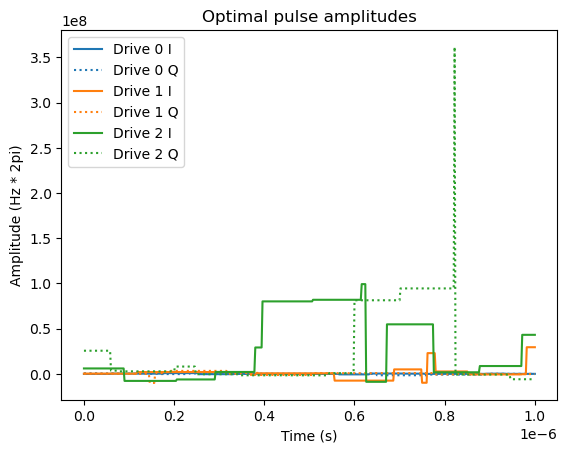

In [43]:
drive_pulse_plot(t_segs, amp_segs)

In [11]:
# Evolution of states over time
print(amp_segs)
x0 = np.append(amp_hist[0].flatten(), opt_freqs[0])
print(f'x0: {x0}')
# args = [num_drives, num_elems, drive_ops, t_segs, t_step, H_0, init_state, c_ops, eval_ops, sim_options, element_ops, element_freqs, output_cost_func, verbose]
# args[]
# (num_drives, drive_ops, time_hist[-1], t_step, H_0, init_state, c_ops, eval_ops, sim_options, element_ops, element_freqs, output_cost_func, verbose)
ti_state_plot(x0, *args)

[[ 1.47097500e+05  4.34678320e+04  2.11682812e+03 -3.74416357e+03
  -2.19897485e+03 -2.19897485e+03  9.94827637e+02  2.62260742e+01
   5.18196106e+01 -8.00743332e+01 -8.00743332e+01 -2.95967432e+03
  -1.45323914e+02 -3.20283032e+03  5.25662231e+01  2.70044023e+04
   2.47761855e+04 -2.07656372e+02  5.96390430e+03]
 [-2.09224156e+05 -1.87897595e+03 -5.08111719e+03  6.19860312e+04
  -9.65163452e+02 -9.65163452e+02 -1.01442531e+05 -2.22233275e+06
  -2.58982375e+06  2.51408125e+05 -7.87024250e+05 -1.77708100e+06
  -8.40678875e+05 -8.40678875e+05 -5.12949492e+04 -1.31681030e+02
  -1.09604691e+02 -8.84888281e+03 -5.60991172e+04]
 [-2.03025203e+05  3.40480273e+03  1.15721125e+05  1.34487638e+06
  -2.23423344e+05  2.39326680e+04  3.14440275e+06  1.09494350e+06
   7.95814688e+05  7.30395625e+05  1.25069414e+05  5.81266438e+05
   2.00908900e+06  6.59775250e+05  6.59775250e+05 -5.56865664e+04
   9.00226562e+03  2.36678477e+04  2.36678477e+04]
 [ 8.88956875e+05  3.92358469e+05 -9.35226875e+04 -1.31

ValueError: cannot reshape array of size 4 into shape (6,0)

In [ ]:
print(cost_hist)

In [ ]:
print(opt_result)

In [ ]:
a = basis(2, 0)

In [ ]:
print(a.full())